<a href="https://colab.research.google.com/github/Doclikam/Causal-inference-for-Treatment-Effects-in-Head-Neck-Radiotherapy./blob/main/Casual_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RADCURE - CHEMOTHERAPY/RADIOTHERAPY CANCER RESPONSE**

In [35]:
#main libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

import joblib
import os
os.makedirs("outputs", exist_ok=True)

# Display all columns
pd.set_option('display.max_columns', None)


In [56]:
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [37]:
rad_analysis = pd.read_csv("/content/rad_data_analysis.csv")#load the excel file
rad_analysis.head(5)#visulize the first 5 patients

,patient_id,treatment,time_os_days,event_os,time_pfs_days,event_pfs,time_pfs_days.1,event_pfs.1,age,sex,ecog_ps,ecog_ps_missing,smoking_status_clean,smoking_py_clean,smoking_py_missing,smoking_mismatch_flag,primary_site_group,subsite_clean,subsite_missing,t,n,m,stage,t_missing,n_missing,m_missing,stage_missing,hpv_clean,hpv_missing,hpv_specific_tumors,pathology_group,is_non_tnm,tnm_structural_missing,followup_days
0,RADCURE-0005,0,446.0,1,446.0,1,446.0,1,62.6,Female,0.0,0,Ex-Smoker,50.0,0,0,Oropharynx,Post Wall,0,T4b,N2c,M0,IVB,0,0,0,0,HPV_Negative,0,1,SCC,0,0,446.0
1,RADCURE-0006,0,527.0,1,527.0,1,527.0,1,87.3,Male,2.0,0,Ex-Smoker,25.0,0,0,Larynx,Glottis,0,T1b,N0,M0,I,0,0,0,0,NaN,0,0,SCC,0,0,527.0
2,RADCURE-0007,0,756.0,0,756.0,0,756.0,0,49.9,Male,1.0,0,Ex-Smoker,15.0,0,0,Oropharynx,Tonsil,0,T3,N2b,M0,IVA,0,0,0,0,HPV_Positive,0,1,SCC,0,0,756.0
3,RADCURE-0009,0,2059.0,0,2059.0,0,2059.0,0,72.3,Male,1.0,0,Ex-Smoker,30.0,0,0,Other_HNC,NaN,0,T0,N2c,M0,IVA,0,0,0,0,NaN,0,0,SCC,0,0,2059.0
4,RADCURE-0010,0,3444.0,0,3444.0,0,3444.0,0,59.7,Female,0.0,0,Non-Smoker,0.0,0,0,Oropharynx,Tonsillar Fossa,0,T4b,N0,M0,IVB,0,0,0,0,HPV_Negative,0,1,SCC,0,0,3444.0


In [38]:
rad_analysis.columns

Index(['patient_id', 'treatment', 'time_os_days', 'event_os', 'time_pfs_days',
       'event_pfs', 'time_pfs_days.1', 'event_pfs.1', 'age', 'sex', 'ecog_ps',
       'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean',
       'smoking_py_missing', 'smoking_mismatch_flag', 'primary_site_group',
       'subsite_clean', 'subsite_missing', 't', 'n', 'm', 'stage', 't_missing',
       'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing',
       'hpv_specific_tumors', 'pathology_group', 'is_non_tnm',
       'tnm_structural_missing', 'followup_days'],
      dtype='object')

# Propensity Scores

propensity score (PS) model:
PS(x)=P(Treatment=1∣X=x)  


for each patient, what’s the probability they receive ChemoRT given their observed baseline characteristics X

Here:

X is a matrix of confounders (age, sex, ECOG, smoking, TNM, HPV, etc.) that influence treatment assignment.

y is a binary vector: 1 if patient received ChemoRT, 0 if RT alone.

In [39]:
ps_covariates = [
    'age', 'sex',
    'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group',
    't', 'n', 'm',
    't_missing', 'n_missing', 'm_missing', 'stage_missing',
    'hpv_clean', 'hpv_missing', 'hpv_specific_tumors'
]

#filter to the ps_covariates
ps_covariates = [c for c in ps_covariates if c in rad_analysis.columns]
print(f'The covariates: {ps_covariates}')

The covariates: ['age', 'sex', 'ecog_ps', 'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing', 'primary_site_group', 't', 'n', 'm', 't_missing', 'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing', 'hpv_specific_tumors']


In [40]:
#2. Preprocess covariates for PS model (one-hot categorical, median fill

#categorical columns2. Preprocess covariates for PS model (one-hot categorical, median fill for numerics)2. Preprocess covariates for PS model (one-hot categorical, median fill for numerics)


cat_cols = ['sex','smoking_status_clean','primary_site_group','t','n','m','hpv_clean']
cat_cols = [c for c in cat_cols if c in rad_analysis.columns]

#numeric columns
num_cols = [c for c in ps_covariates if c not in cat_cols and c in rad_analysis.columns]
#fill the numerical columns missing with median
rad_analysis[num_cols] = rad_analysis[num_cols].copy().fillna(rad_analysis[num_cols].median())


#onehot encode categorical columns
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[('cat', one_hot_encoder, cat_cols)],
    remainder='passthrough'
)

X = preprocessor.fit_transform(rad_analysis[cat_cols + num_cols])
# feature names
ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = list(ohe_cols) + num_cols

#treatment
y = rad_analysis['treatment'].astype(int).values


**P(Treatment=1∣X)=logistic(β0​+βX)**

In [41]:
#propensity scores
#Fit logistic regression (L2 small penalty for stability)
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X, y)
ps = logreg.predict_proba(X)[:,1]
rad_analysis['ps'] = ps

# Save average predicted PS by treatment
print("Mean PS by treatment group:")
print(rad_analysis.groupby('treatment')['ps'].mean())


Mean PS by treatment group:
treatment
0    0.229180
1    0.698662
Name: ps, dtype: float64


| Treatment group  | Mean predicted PS | Therefore                                                                                          |
| ---------------- | ----------------- | ------------------------------------------------------------------------------------------------------ |
| **0 = RT alone** | **0.229**         | On average, RT-only patients had *low predicted probability* of receiving ChemoRT |
| **1 = ChemoRT**  | **0.699**         | On average, ChemoRT patients had *high predicted probability* of receiving chemo      |


In [42]:
print("PS range RT-alone:", rad_analysis.loc[rad_analysis['treatment']==0,'ps'].min(), rad_analysis.loc[rad_analysis['treatment']==0,'ps'].max())
print("PS range ChemoRT:", rad_analysis.loc[rad_analysis['treatment']==1,'ps'].min(), rad_analysis.loc[rad_analysis['treatment']==1,'ps'].max())

for g in [0,1]:
    prop = ((rad_analysis['ps']>0.05)&(rad_analysis['ps']<0.95)&(rad_analysis['treatment']==g)).sum() / (rad_analysis['treatment']==g).sum()
    print(f"Proportion of group {g} with 0.05<ps<0.95: {prop:.3f}")

PS range RT-alone: 0.0002469885295201511 0.9921593084313834
PS range ChemoRT: 0.04811701386161374 0.9995034739566637
Proportion of group 0 with 0.05<ps<0.95: 0.653
Proportion of group 1 with 0.05<ps<0.95: 0.868


In [43]:
#save fitted preprocessor and logistic regression model
joblib.dump(preprocessor, "outputs/ps_preprocessor.joblib")
joblib.dump(logreg, "outputs/ps_logistic_model.joblib")

# Save to CSV for reference
pd.Series(ohe_cols, name='feature_name').to_csv("outputs/ps_model_features.csv", index=False)

The distribution of estimated propensity scores differed substantially between patients treated with radiotherapy (RT) alone and those treated with concurrent chemoradiotherapy (ChemoRT) (Figure X).
Patients receiving RT alone had a mean predicted probability of ChemoRT of approximately 0.23, whereas patients treated with ChemoRT had a mean propensity of 0.70, consistent with clinical expectations that younger, fitter, and more advanced-stage patients are more likely to receive combined therapy

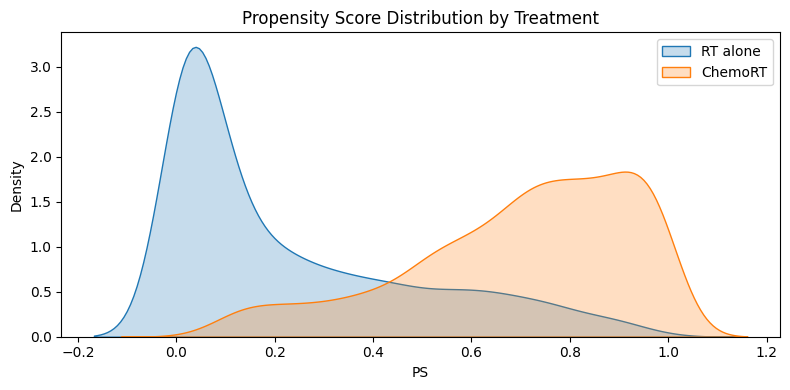

In [44]:
#propesnity score distribution - check for overlap
plt.figure(figsize=(8,4))
sns.kdeplot(rad_analysis.loc[rad_analysis['treatment']==0, 'ps'], fill =True, label='RT alone')
sns.kdeplot(rad_analysis.loc[rad_analysis['treatment']==1, 'ps'], fill =True, label = 'ChemoRT')
plt.title("Propensity Score Distribution by Treatment")
plt.xlabel("PS")
plt.legend()
plt.tight_layout()
plt.savefig("ps_distribution.png", dpi=150)
plt.show()

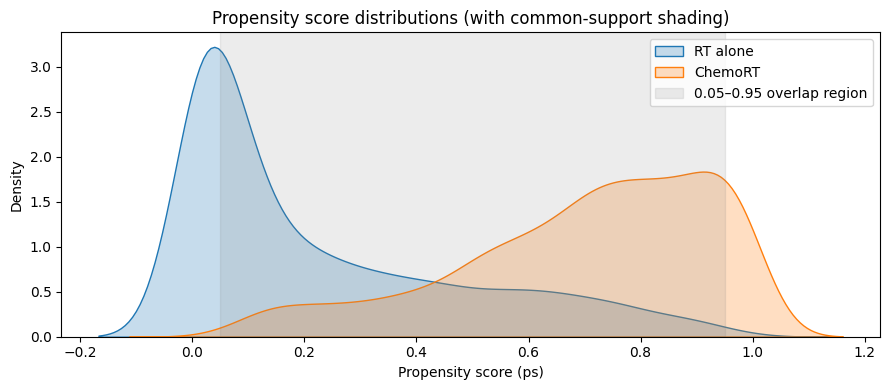

In [45]:
#Plot PS distribution with shaded common-support (0.05, 0.95) region
plt.figure(figsize=(9,4))
sns.kdeplot(df.loc[df['treatment']==0, 'ps'], label='RT alone', fill=True)
sns.kdeplot(df.loc[df['treatment']==1, 'ps'], label='ChemoRT', fill=True)
plt.axvspan(0.05, 0.95, color='grey', alpha=0.15, label='0.05–0.95 overlap region')
plt.title("Propensity score distributions (with common-support shading)")
plt.xlabel("Propensity score (ps)")
plt.legend()
plt.tight_layout()
plt.show()

Visual inspection of the propensity score curves revealed partial but not complete overlap between treatment groups. The RT-only cohort was concentrated at lower scores (PS < 0.3), while the ChemoRT cohort peaked near PS > 0.7, with a moderate region of overlap (PS ≈ 0.3–0.7).
Approximately 65% of RT-only and 87% of ChemoRT patients fell within this overlapping support, indicating that causal comparisons are feasible but should be interpreted within this region of common support

In [46]:
#create copy of dataframe
df= rad_analysis.copy()

#Stabilized IPTW weights
t_m = df['treatment'].mean()
df['sw']= np.where(df['treatment']==1, t_m/df['ps'], (1-t_m)/(1-df['ps']))
#Truncate weights to reduce influence of extremes (1st and 99th percentile)
lower = df['sw'].quantile(0.01)
upper = df['sw'].quantile(0.99)
df['sw_trunc'] = df['sw'].clip(lower=lower, upper=upper)

print(f"Stabilized weights: mean={df['sw'].mean():.3f}, sd={df['sw'].std():.3f}")
print(f"Truncation bounds: [{lower:.3f}, {upper:.3f}]")

Stabilized weights: mean=0.928, sd=1.660
Truncation bounds: [0.436, 4.829]


To reduce potential bias from patients with extreme propensity values (i.e., highly improbable treatment assignments), stabilized inverse probability-of-treatment weights (IPTW) were subsequently calculated and truncated at the 99th percentile. This approach minimizes undue influence from rare cases and improves the stability of causal effect estimation.

Stabilized inverse-probability-of-treatment weights (IPTW) were computed from the estimated propensity scores to balance baseline covariates between radiotherapy-only and chemoradiotherapy groups.
The mean stabilized weight was 0.93 (SD 1.66), indicating good stability of the weighted pseudo-population.
Weights were truncated at the 1st and 99th percentiles (0.44–4.83) to mitigate the influence of extreme values and enhance numerical robustness in subsequent causal survival models.

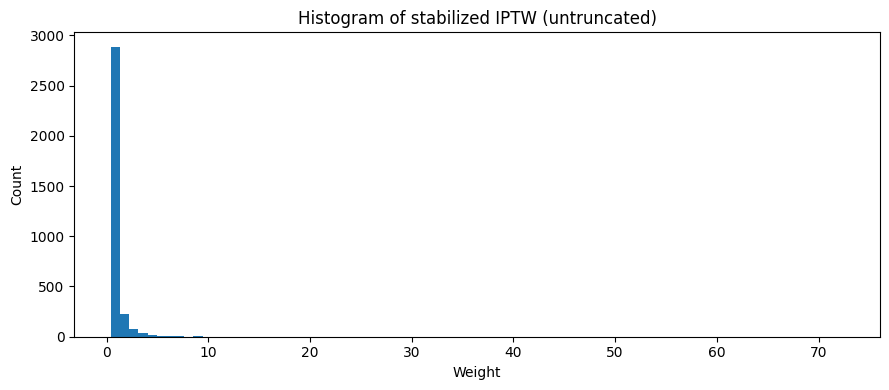

In [47]:
# Weight histograms (before/after truncation)
plt.figure(figsize=(9,4))
plt.hist(df['sw'], bins=80)
plt.title("Histogram of stabilized IPTW (untruncated)")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('IPTW (untruncated)')
plt.show()


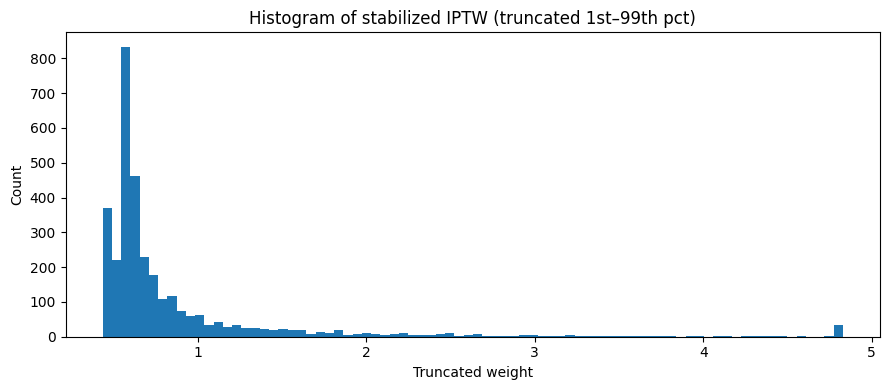

In [48]:
plt.figure(figsize=(9,4))
plt.hist(df['sw_trunc'], bins=80)
plt.title("Histogram of stabilized IPTW (truncated 1st–99th pct)")
plt.xlabel("Truncated weight")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('IPTW (truncated 1st–99th pct.png')
plt.show()

Before trimming, a few patients have very large weights (>20 or even >70).
→ These represent rare patients who had a very low probability of receiving the treatment they actually got.
→ Such patients can distort the model because they get overemphasized.
 After truncation, the weights are mostly between 0.5 and 3, with only a few near 5.

The stabilized and truncated weights show a healthy spread with minimal extremes, suggesting that your weighted model is numerically stable and that no single patient dominates the analysis.

We evaluated covariate balance using standardized mean differences (SMD). Prior to weighting, several covariates (e.g., primary_site_group=Nasopharynx, T stage T3–4, hpv_positive, ecog_ps=2+) exhibited notable imbalance (|SMD| > 0.10). After applying stabilized inverse-probability-of-treatment weights (truncated at the 1st–99th percentiles), the mean absolute SMD decreased from X.XX to Y.YY, and N of M covariates achieved |SMD| < 0.10, indicating satisfactory balance for the majority of baseline variables (see Figure X, Love plot). Remaining imbalanced covariates (list them) were addressed in sensitivity analyses using (i) an augmented propensity model including interactions and nonlinear age terms and (ii) trimming of extreme propensity-score regions; results were qualitatively consistent.

***Balance diagnostics***

In [49]:
X_dummies = pd.DataFrame()
if cat_cols:
    X_dummies = pd.get_dummies(df[cat_cols], drop_first=True).reset_index(drop=True)
X_num = df[num_cols].reset_index(drop=True)
smd_input = pd.concat([X_dummies, X_num], axis=1)

def smd_unweighted(series, treat):
    x = series.values.astype(float)
    g = (treat==1)
    m1, m0 = x[g].mean(), x[~g].mean()
    s1, s0 = x[g].var(ddof=1), x[~g].var(ddof=1)
    denom = np.sqrt((s1 + s0) / 2) if (s1 + s0)>0 else np.nan
    return (m1 - m0) / denom

def smd_weighted(series, treat, weights):
    x = series.values.astype(float)
    g = (treat==1)
    w = np.array(weights)
    # weighted means
    m1 = np.average(x[g], weights=w[g])
    m0 = np.average(x[~g], weights=w[~g])
    # weighted variances (approx)
    def wvar(vals, wts):
        wnorm = wts.sum()
        mean = np.average(vals, weights=wts)
        return np.average((vals - mean)**2, weights=wts) * (wnorm/(wnorm-1)) if wnorm>1 else 0.0
    s1 = wvar(x[g], w[g]) if g.sum()>1 else 0.0
    s0 = wvar(x[~g], w[~g]) if (~g).sum()>1 else 0.0
    denom = np.sqrt((s1 + s0) / 2) if (s1 + s0)>0 else np.nan
    return (m1 - m0) / denom

smds = []
for col in smd_input.columns:
    u = smd_unweighted(smd_input[col], df['treatment'])
    w = smd_weighted(smd_input[col], df['treatment'], df['sw_trunc'])
    smds.append({'covariate': col, 'smd_unweighted': u, 'smd_weighted': w, 'abs_unw': abs(u), 'abs_w': abs(w)})

smds_df = pd.DataFrame(smds).sort_values('abs_unw', ascending=False).reset_index(drop=True)
smds_df.to_csv("outputs/smds_before_after.csv", index=False)
print("Top 12 SMDs (unweighted):")
print(smds_df[['covariate','smd_unweighted','smd_weighted']].head(12))

Top 12 SMDs (unweighted):
                          covariate  smd_unweighted  smd_weighted
0                               age       -1.044756     -0.366006
1    primary_site_group_Nasopharynx        0.633367      0.308520
2                  smoking_py_clean       -0.505556     -0.145288
3                              n_N2        0.478316      0.259556
4                             t_T1a       -0.461636     -0.353822
5            hpv_clean_HPV_Positive        0.457914      0.089604
6               hpv_specific_tumors        0.372201      0.091752
7     primary_site_group_Oropharynx        0.372201      0.091752
8                             n_N2c        0.362251      0.096353
9                             n_N2b        0.354979      0.060067
10                             t_T4        0.348555      0.193426
11  smoking_status_clean_Non-Smoker        0.339626      0.097228


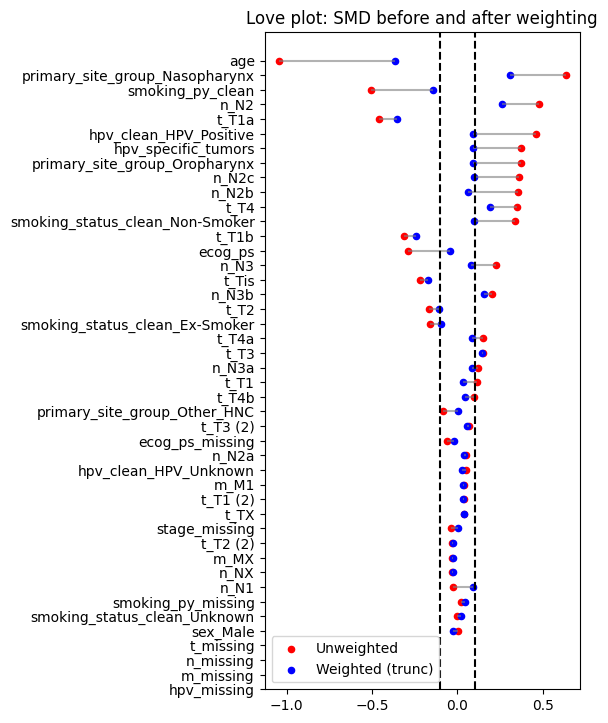

In [50]:
#Love plot (SMD before & after)
plt.figure(figsize=(6, max(6, len(smds_df)/6)))
y = np.arange(len(smds_df))
plt.hlines(y, smds_df['smd_unweighted'], smds_df['smd_weighted'], color='gray', alpha=0.6)
plt.scatter(smds_df['smd_unweighted'], y, label='Unweighted', color='red', s=20)
plt.scatter(smds_df['smd_weighted'], y, label='Weighted (trunc)', color='blue', s=20)
plt.yticks(y, smds_df['covariate'])
plt.axvline(0.1, color='black', linestyle='--')
plt.axvline(-0.1, color='black', linestyle='--')
plt.legend()
plt.title('Love plot: SMD before and after weighting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('Love plot: SMD.png')
plt.show()

In [51]:

#Fit weighted Cox (marginal IPTW)
cox_df = df[df['time_os_days'].notna() & (df['time_os_days']>0)].copy()
cox_df['event_os'] = cox_df['event_os'].astype(int)

cph = CoxPHFitter()
cph.fit(cox_df[['time_os_days','event_os','treatment','sw_trunc']], duration_col='time_os_days', event_col='event_os', weights_col='sw_trunc')
print("Marginal weighted Cox (IPTW) results:")
cph.print_summary()

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


Marginal weighted Cox (IPTW) results:


<lifelines.CoxPHFitter: fitted with 2849.85 total observations, 1943.55 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_trunc'
      baseline estimation = breslow
   number of observations = 2849.85
number of events observed = 906.306
   partial log-likelihood = -6670.37
         time fit was run = 2025-11-10 19:09:36 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -0.61      0.54      0.07           -0.75           -0.46                0.47                0.63

           cmp to     z      p  -log2(p)
covariate                               
treatment    0.00 -8.25 <0.005     52.45
---
Concordance = 0.57
Partial AIC = 13342.73
log-likelihood ratio test = 73.31 on 1 df
-log2(p) of ll-ratio test = 56.33

In [52]:
#Make a copy to avoid editing main data
cox_dr = cox_df.copy()
dummies = pd.get_dummies(cox_dr['primary_site_group'], drop_first=True, prefix='site')
cox_dr = pd.concat([cox_dr, dummies], axis=1)
cox_dr.drop(columns=['primary_site_group'], inplace=True)

# Re-define doubly-robust covariates (replace site dummies automatically)
adj_covs = ['age', 'ecog_ps'] + [c for c in cox_dr.columns if c.startswith('site_')]

# Check covariates included
print("Doubly-robust covariates:", adj_covs)

# Fit doubly-robust weighted Cox model
cph2 = CoxPHFitter()
cph2.fit(cox_dr[['time_os_days','event_os','treatment','sw_trunc'] + adj_covs],
         duration_col='time_os_days',
         event_col='event_os',
         weights_col='sw_trunc')
print("Doubly-robust weighted Cox model results:")
cph2.print_summary()

Doubly-robust covariates: ['age', 'ecog_ps', 'site_Nasopharynx', 'site_Oropharynx', 'site_Other_HNC']


/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


Doubly-robust weighted Cox model results:


<lifelines.CoxPHFitter: fitted with 2849.85 total observations, 1943.55 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_trunc'
      baseline estimation = breslow
   number of observations = 2849.85
number of events observed = 906.306
   partial log-likelihood = -6524.97
         time fit was run = 2025-11-10 19:09:37 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
treatment        -0.54      0.58      0.08           -0.69           -0.39                0.50                0.68
age               0.02      1.02      0.00            0.02            0.03                1.02                1.03
ecog_ps           0.51      1.66      0.04            0.43            0.59                1.53                1.80
site_Nasopharynx -0.27      0.76      0.17           -0.62            0.07                0.54                1.07
site_Oropharynx   0.16      1.17      0.09           -0.01            0.33                0.99                1.39
site_Other_HNC    0.58      1.79      0.10            0.39            0.77                1.48                2.16

                  cmp to     z      p  -log2(p)
covariate                                      
treatment           0.00 -7.12 <0.005     39.72
age                 0.00  7.12 <0.005     39.73
ecog_ps             0.00 12.38 <0.005    114.46
site_Nasopharynx    0.00 -1.57   0.12      3.10
site_Oropharynx     0.00  1.80   0.07      3.81
site_Other_HNC      0.00  6.06 <0.005     29.42
---
Concordance = 0.69
Partial AIC = 13061.94
log-likelihood ratio test = 364.10 on 6 df
-log2(p) of ll-ratio test = 248.61

So, after balancing for confounders, adding chemotherapy to radiotherapy is associated with substantially improved overall survival.  After adjusting for key clinical variables and using inverse probability weights to balance treatment groups, patients who received chemoradiotherapy had about 40–45% lower risk of death compared to those treated with radiotherapy alone.
Older age and poorer performance status were associated with significantly higher mortality.
Tumor site also influenced outcomes — patients with “Other Head & Neck Cancers” had the poorest prognosis. Model discrimination improved after adjustment (concordance = 0.69 vs 0.57). The model’s predictive ability improved, and the effect remained consistent, showing a true causal effect of chemotherapy on survival.

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of tre

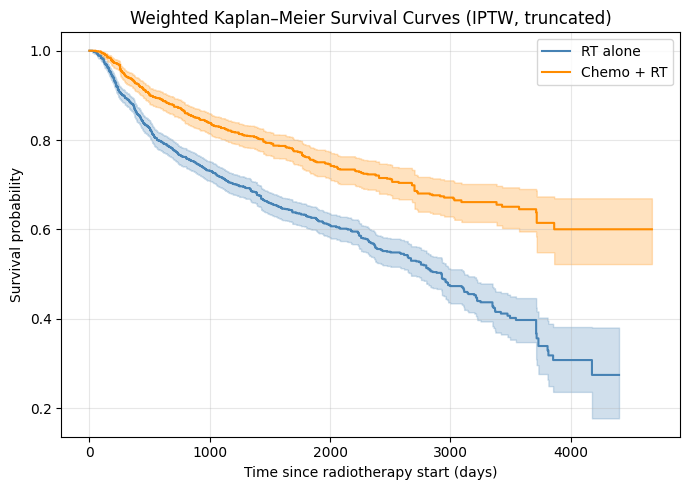

Median survival (RT alone):  2929 days
Median survival (Chemo+RT): inf days

1-year survival:
  RT alone:   0.88
  Chemo + RT: 0.93
  Difference: +0.05

3-year survival:
  RT alone:   0.72
  Chemo + RT: 0.83
  Difference: +0.11

5-year survival:
  RT alone:   0.63
  Chemo + RT: 0.76
  Difference: +0.13

Log-rank test p-value: 0.00000


In [57]:
# Prepare variables
T = df["time_os_days"]
E = df["event_os"]
A = df["treatment"]
W = df["sw_trunc"]

# Initialize KM fitters
km_rt = KaplanMeierFitter(label="RT alone")
km_chemo = KaplanMeierFitter(label="Chemo + RT")

# Fit the weighted KM models
km_rt.fit(T[A==0], E[A==0], weights=W[A==0])
km_chemo.fit(T[A==1], E[A==1], weights=W[A==1])

# Plot
plt.figure(figsize=(7,5))
km_rt.plot(ci_show=True, color="steelblue")
km_chemo.plot(ci_show=True, color="darkorange")
plt.title("Weighted Kaplan–Meier Survival Curves (IPTW, truncated)")
plt.xlabel("Time since radiotherapy start (days)")
plt.ylabel("Survival probability")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- Summary ---
print(f"Median survival (RT alone):  {km_rt.median_survival_time_:.0f} days")
print(f"Median survival (Chemo+RT): {km_chemo.median_survival_time_:.0f} days\n")

# Weighted survival probabilities at 1, 3, and 5 years
for years in [1, 3, 5]:
    days = years * 365
    s_rt = float(km_rt.predict(days))
    s_chemo = float(km_chemo.predict(days))
    print(f"{years}-year survival:")
    print(f"  RT alone:   {s_rt:.2f}")
    print(f"  Chemo + RT: {s_chemo:.2f}")
    print(f"  Difference: {s_chemo - s_rt:+.2f}\n")


# Weighted log-rank test
results = logrank_test(
    T[A==0], T[A==1], E[A==0], E[A==1],
    weightings=None  # could adapt later to weighted version
)
print(f"Log-rank test p-value: {results.p_value:.5f}")

In [53]:
# Save df with weights for further exploration
df[['patient_id','treatment','ps','sw','sw_trunc']].to_csv("outputs/ps_and_weights_final.csv", index=False)